In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
from eofs.xarray import Eof
from xarrayutils.utils import linear_trend
import gc
import collections
import statsmodels.api as sm
import scipy

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'

In [3]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
iceshelves_dedrafted_total = xr.open_dataset(inDirName+
                                             interim_data_folder+
                                             flux_dedrafted_iceshelves_data_path+
                                             'iceshelves_dedrafted_total.nc')

In [4]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [7]:
reconstr_full = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_n_{}'.
                                format(0))
flux_reconstr = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux

In [9]:
amery_basin = 34
amery_flux = flux_clean.rio.clip(icems.loc[[amery_basin],'geometry'].apply(mapping),icems.crs,drop=False)
amflux = amery_flux.fillna(0)
flux_amremoved = flux_clean - amflux

In [46]:
reconstr_full = xr.open_dataset(inDirName+
                                interim_data_folder+
                                randomized_realizations_path+
                                'Resid_randomized_flux_EOF1RM_n_{}'.
                                format(0))
flux_reconstr_amremoved = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux

In [47]:
basin = 104

flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr.rio.write_crs("epsg:3031",inplace=True);
flux_amremoved.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr_amremoved.rio.write_crs("epsg:3031",inplace=True);

orig_basin = flux_clean.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)

rec_basin = flux_reconstr.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)

orig_amremoved_basin = flux_amremoved.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)

rec_amremoved_basin = flux_reconstr_amremoved.rio.clip(icems.
                                   loc[[basin],'geometry'].
                                   apply(mapping),icems.crs,drop=False)


# Remove NaN mask values to 'zoom' into catchment region
orig_basin = orig_basin.dropna('time',how='all')
orig_basin = orig_basin.dropna('y',how='all')
orig_basin = orig_basin.dropna('x',how='all')

rec_basin = rec_basin.dropna('time',how='all')
rec_basin = rec_basin.dropna('y',how='all')
rec_basin = rec_basin.dropna('x',how='all')

orig_basin = orig_basin.drop("month")
rec_basin = rec_basin.drop("month")


orig_amremoved_basin = orig_amremoved_basin.dropna('time',how='all')
orig_amremoved_basin = orig_amremoved_basin.dropna('y',how='all')
orig_amremoved_basin = orig_amremoved_basin.dropna('x',how='all')

rec_amremoved_basin = rec_amremoved_basin.dropna('time',how='all')
rec_amremoved_basin = rec_amremoved_basin.dropna('y',how='all')
rec_amremoved_basin = rec_amremoved_basin.dropna('x',how='all')

orig_amremoved_basin = orig_amremoved_basin.drop("month")
rec_amremoved_basin = rec_amremoved_basin.drop("month")

In [48]:
# Time series of selected catchment for comparison between original and reconstruction
orig_basin_ts = orig_basin.sum(['y','x'])
rec_basin_ts = rec_basin.sum(['y','x'])

orig_amremoved_basin_ts = orig_amremoved_basin.sum(['y','x'])
rec_amremoved_basin_ts = rec_amremoved_basin.sum(['y','x'])

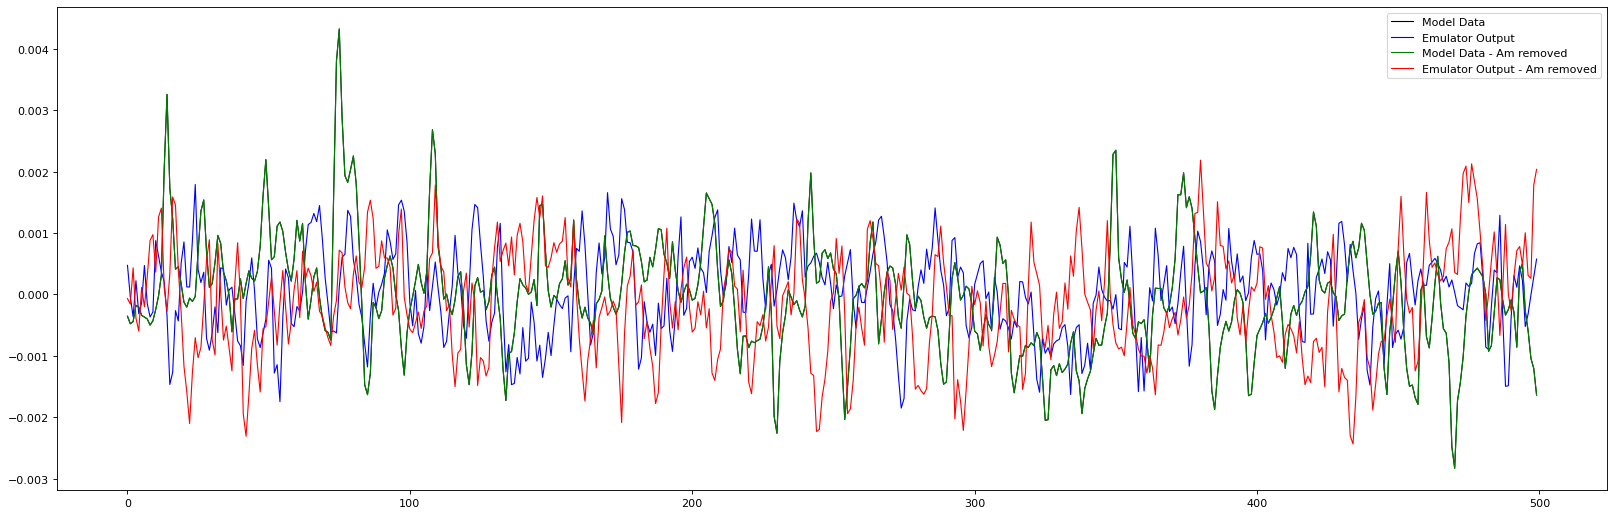

In [49]:
plt.figure(figsize=(25, 8), dpi=80)

t0 = 0
tf = 500

plt.plot(orig_basin_ts[t0:tf], 'k', linewidth=1, label = 'Model Data')
plt.plot(rec_basin_ts[t0:tf],  'b', linewidth=1, label = 'Emulator Output')
plt.plot(orig_amremoved_basin_ts[t0:tf], 'g', linewidth=1, label = 'Model Data - Am removed')
plt.plot(rec_amremoved_basin_ts[t0:tf],  'r', linewidth=1, label = 'Emulator Output - Am removed')
plt.legend()

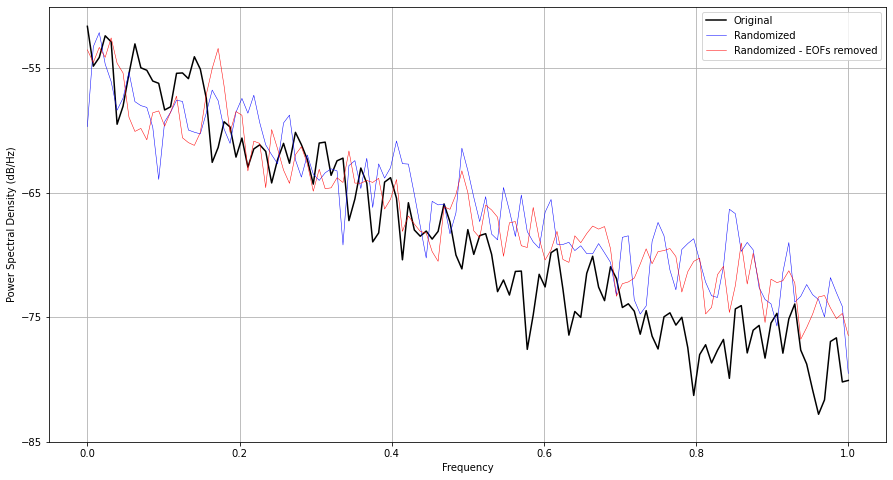

In [51]:
# test psd

plt.figure(figsize=(15,8))
plt.psd(orig_basin_ts,label='Original', color='k')
plt.psd(rec_basin_ts,label='Randomized', color = 'b', linewidth=0.5)
#plt.psd(orig_amremoved_basin_ts,label='Original - Am removed', color='g')
plt.psd(rec_amremoved_basin_ts,label='Randomized - EOFs removed', color = 'r', linewidth=0.5)
plt.legend()

In [60]:
orig_basin_ts.std()

<xarray.DataArray 'timeMonthly_avg_landIceFreshwaterFlux' ()>
array(0.0008229)
Coordinates:
    spatial_ref  int64 0

In [61]:
rec_basin_ts.std()

<xarray.DataArray 'timeMonthly_avg_landIceFreshwaterFlux' ()>
array(0.00075995)
Coordinates:
    spatial_ref  int64 0

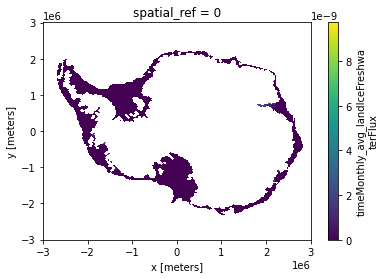

In [63]:
flux_clean.var('time').plot()